# Trabalho final

In [137]:
%matplotlib notebook
import random
import numpy as np, numpy.random
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from pyomo.environ import *
import time
import logging
logging.getLogger('pyomo.core').setLevel(logging.ERROR)

# Primeira Parte

# Ponderações

In [2]:
def modelo_metodoPonderacoes(W1, W2, W3):
    # Inicializa o problema p que será resolvido com o solver
    p = ConcreteModel()
    
    # Declarar Variáveis 
    p.x1 = Var(bounds=(-3,3))
    p.x2 = Var(bounds=(-3,3))
     
    # Função 2
    p.f1 = 1/2*((p.x1**2) + (p.x2**2)) + sin((p.x1**2) + (p.x2**2))
    
    p.f2 = ((3*p.x1 - 2*p.x2 + 4)**2)/8 + ((p.x1 - p.x2 + 1)**2)/27 + 15
    
    p.f3 = 1/(p.x1**2 + p.x2**2 + 1) - (1.1*exp(-p.x1**2 - p.x2**2))

    # declaro a função-objetivo
    p.obj = Objective(expr= W1*p.f1 + W2*p.f2 + W3*p.f3, sense = minimize)
    
    # Resolve
    solver = SolverFactory('ipopt')
    solver.solve(p, tee=False)

    f1 = 1/2*((p.x1**2) + (p.x2**2)) + sin((p.x1**2) + (p.x2**2))
    f2 = ((3*p.x1 - 2*p.x2 + 4)**2)/8 + ((p.x1 - p.x2 + 1)**2)/27 + 15
    f3 = 1/(p.x1**2 + p.x2**2 + 1) - (1.1*exp(-p.x1**2 - p.x2**2))

    return [f1(), f2(), f3()]

In [3]:
def metodoPonderacoes():
    inicio = time.time()
    discretizacoes = np.arange(0.0 ,1.1, 0.1)
    pontosf = []
    for W1 in discretizacoes: 
        for W2 in discretizacoes: 
            W3 = 1 - (W1 + W2)
            if W1 >= 0 and W2 >= 0 and W3 >= 0:
                ponto = modelo_metodoPonderacoes(W1, W2, W3)
                pontosf.append(ponto)       
    fim = time.time()
    return pontosf, fim - inicio

In [4]:
pontosf, tempo1 = metodoPonderacoes()
print('***Método das Ponderações***')
print(f'Pontos: {len(pontosf)}')
print("________________________________")
print("Tempo de execução: ", tempo1)
print("Média: ", np.mean(pontosf))
print("Desvio: ", np.std(pontosf))
print("Melhor Indivíduo: ")
print("Pior Indivíduo: ")

***Método das Ponderações***
Pontos: 66
________________________________
Tempo de execução:  3.300269603729248
Média:  5.435924306025876
Desvio:  7.338706847414459
Melhor Indivíduo: 
Pior Indivíduo: 


<IPython.core.display.Javascript object>


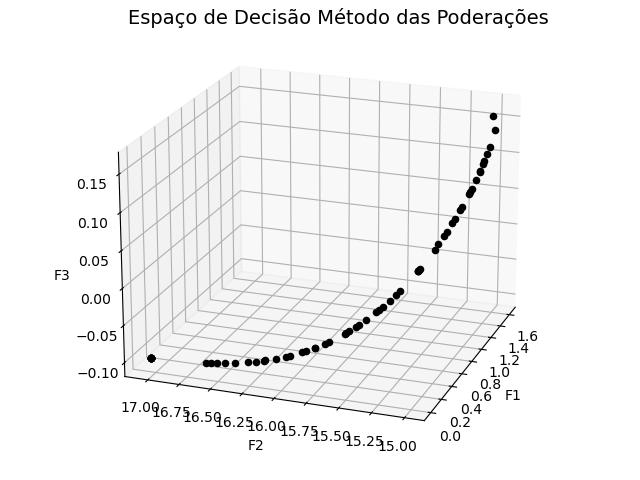

In [22]:
fig2 = plt.figure()         
ax2 = Axes3D(fig2)
for i in range(len(pontosf)):
    ax2.scatter(pontosf[i][0], pontosf[i][1], pontosf[i][2], c='black')
ax2.text2D(0.10, 0.95, "Espaço de Decisão Método das Poderações", transform=ax2.transAxes, fontsize=14)
ax2.set_xlabel('F1')
ax2.set_ylabel('F2')
ax2.set_zlabel('F3')
ax2.view_init(20, 200)    
plt.show()

# E-Restrito

In [6]:
def modelo_metodoEpsilonRestrito(epsilon1, epsilon2):
    # Inicializa o problema p que será resolvido com o solver
    p = ConcreteModel()

    p.x1 = Var(bounds=(-3,3))
    p.x2 = Var(bounds=(-3,3))
     
    # pega a função três e trasforma em restrição
    p.rest1 = Constraint(expr = ((3*p.x1 - 2*p.x2 + 4)**2)/8 + ((p.x1 - p.x2 + 1)**2)/27 + 15 <= epsilon1)
    
    p.rest2 = Constraint(expr = 1/(p.x1**2 + p.x2**2 + 1) - (1.1*exp(-p.x1**2 - p.x2**2)) <= epsilon2)

    # declaro a função-objetivo 1
    p.obj1 = Objective(expr = 1/2*((p.x1**2) + (p.x2**2)) + sin((p.x1**2) + (p.x2**2)), sense=minimize)

    # Resolve
    solver = SolverFactory('ipopt')
    solver.solve(p, tee=False)

    f1 = (1/2)*((p.x1()**2) + (p.x2()**2)) + sin((p.x1()**2) + (p.x2()**2))
    f2 = ((3*p.x1() - 2*p.x2() + 4)**2)/8 + ((p.x1() - p.x2() + 1)**2)/27 + 15
    f3 = 1/(p.x1()**2 + p.x2()**2 + 1) - (1.1*exp(-p.x1()**2 - p.x2()**2))

    return [f1, f2, f3]   # retorna o ponto

In [7]:
def metodoEpsilonRestrito(dispersao=110):
    inicio = time.time()
    [minf1, maxf2_1, maxf3_1] = modelo_metodoPonderacoes(1, 0, 0)
    [maxf1_2, minf2, maxf3_2] = modelo_metodoPonderacoes(0, 1, 0)
    [maxf1_3, maxf2_3, minf3] = modelo_metodoPonderacoes(0, 0, 1)

    # Verificar qual o max do epsilon1 e epsilon2 
    epsilons1 = np.linspace(minf2, max(maxf2_1, maxf2_3), dispersao)
    epsilons2 = np.linspace(minf3, max(maxf3_1, maxf3_2), dispersao)
    
    pontosf = []
    for epsilon1, epsilon2 in zip(epsilons1, epsilons2):
        ponto = modelo_metodoEpsilonRestrito(epsilon1, epsilon2)
        pontosf.append(ponto)
    fim = time.time()
    return pontosf, fim - inicio

In [8]:
pontosf2, tempo2 = metodoEpsilonRestrito()
print('***Método Epsolon-Restrito***')
print(f'Pontos: {len(pontosf2)}')
print("________________________________")
print("Tempo de execução: ", tempo2)
print("Média: ", np.mean(pontosf2))
print("Desvio: ", np.std(pontosf2))
print("Melhor Indivíduo: ")
print("Pior Indivíduo: ")

***Método Epsolon-Restrito***
Pontos: 110
________________________________
Tempo de execução:  5.811748743057251
Média:  5.6207743337681855
Desvio:  7.467797211381197
Melhor Indivíduo: 
Pior Indivíduo: 


<IPython.core.display.Javascript object>


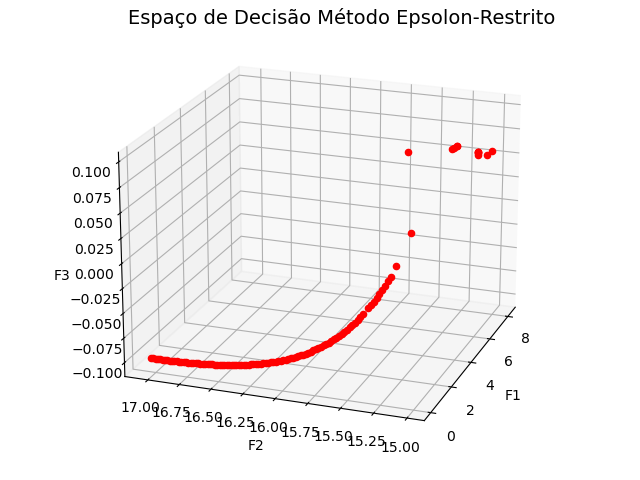

In [23]:
fig2 = plt.figure()         
ax2 = Axes3D(fig2)
for i in range(len(pontosf2)):
    ax2.scatter(pontosf2[i][0], pontosf2[i][1], pontosf2[i][2], c='red') 
ax2.text2D(0.10, 0.95, "Espaço de Decisão Método Epsolon-Restrito", transform=ax2.transAxes, fontsize=14)
ax2.set_xlabel('F1')
ax2.set_ylabel('F2')
ax2.set_zlabel('F3')    
ax2.view_init(20, 200)
plt.show()

# NSGA-II

In [209]:
# 2 pais são aleatoriamente selecionados da populacao
# gerando 2 filhos através de crossover aritmético
def crossover(populacao, TX_crossover, TP, VAR):
    filhos = np.zeros((TX_crossover, VAR))
    for i in range(int(TX_crossover/2)):
        r1 = np.random.randint(0, TP)   # intervalo [0, TP)
        r2 = np.random.randint(0, TP)
        while r1 == r2:
            r2 = np.random.randint(0, TP)
        alpha = np.random.uniform(0,1)
        for j in range(VAR):
            filhos[2*i, j] = alpha*populacao[r1, j] + (1-alpha)*populacao[r2, j]
            filhos[2*i+1, j] = alpha*populacao[r2, j] + (1-alpha)*populacao[r1, j]      

    return filhos   

# 2 pais são aleatoriamente selecionados da populacao
# gerando 2 filhos através de troca de coordenadas
def mutacao(populacao, TX_mutacao, TP, VAR):
    filhos = np.zeros((TX_mutacao, VAR))
    for i in range(int(TX_mutacao/2)):
        r1 = np.random.randint(0, TP)
        r2 = np.random.randint(0, TP)
        while r1 == r2:
            r2 = np.random.randint(0, TP)
        var_troca = np.random.randint(0, VAR)
        filhos[2*i] = populacao[r1]
        filhos[2*i, var_troca] = populacao[r2, var_troca]
        filhos[2*i+1] = populacao[r2]
        filhos[2*i+1, var_troca] = populacao[r1, var_troca]

    return filhos

# 1 individuo da populacao é selecionado aleatoriamente
# gerando um individuo através de uma perturbação em uma das variáveis
def busca_local(populacao, TX_busca_local, passo_busca, TP, VAR, LB, UB):
    filhos = np.zeros((TX_busca_local, VAR))
    for i in range(TX_busca_local):
        ind = np.random.randint(0, TP)
        individuo = populacao[ind, :]
        
        v = np.random.randint(0, VAR)
        individuo[v] += np.random.uniform(-passo_busca, passo_busca)
        
        if individuo[v] < LB[v]:
            individuo[v] = LB[v]
        if individuo[v] > UB[v]:
            individuo[v] = UB[v]

        filhos[i,:] = individuo
    return filhos

# Kursawe function - https://en.wikipedia.org/wiki/Test_functions_for_optimization
def avalia_populacao(populacao):
    TPtotal = populacao.shape[0]  # qtde de linhas da populacao
    funcoes = np.zeros((TPtotal, 3)) # 3 funções-objetivo
    for ind,x in enumerate(populacao):
        
        obj1 = 1/2*((x[0]**2) + (x[1]**2)) + sin((x[0]**2) + (x[1]**2))
        obj2 = ((3*x[0] - 2*x[1] + 4)**2)/8 + ((x[0] - x[1] + 1)**2)/27 + 15
        obj3 = 1/(x[0]**2 + x[1]**2 + 1) - (1.1*exp(-x[0]**2 - x[1]**2))
        
        funcoes[ind,0] = obj1
        funcoes[ind,1] = obj2
        funcoes[ind,2] = obj3

    return funcoes

def crowding(fitness):
    tam_pop = len(fitness[:, 0])   # quantidade de pontos
    funcoes = len(fitness[0, :])   # quantidade de funções-objetivo               
    matriz_crowding = np.zeros((tam_pop, funcoes))  
    # fitness.ptp(0) array com máximos de cada coluna
    fitness_normalizado = (fitness - fitness.min(0))/fitness.ptp(0)  
    
    # para cada função-objetivo
    for i in range(funcoes):
        crowding_resultado = np.zeros(tam_pop)
        
        # pontos extremos tem o maior resultado de crowding
        crowding_resultado[0] = 1             
        crowding_resultado[tam_pop - 1] = 1    
        
        fitness_normalizado_ordenado = np.sort(fitness_normalizado[:,i])
        indices_fitness_normalizado = np.argsort(fitness_normalizado[:,i])
        
        # crowding distance: solução i, crowding = fitness[i+1] - fitness[i-1]
        crowding_resultado[1:tam_pop-1] = (fitness_normalizado_ordenado[2:tam_pop] - fitness_normalizado_ordenado[0:tam_pop-2])
        reordenar = np.argsort(indices_fitness_normalizado)
        matriz_crowding[:, i] = crowding_resultado[reordenar]
    
    crowding_distance = np.sum(matriz_crowding, axis=1) 

    return crowding_distance   

def seleciona_com_crowding(fitness, qtde):
    # atribui índices às soluções sob análise: da última fronteira
    indices = np.arange(fitness.shape[0])
    
    # soluções que serão selecionadas
    solucoes_selecionadas = np.zeros(qtde)
    
    # calcula o crowding distance
    crowding_distance = crowding(fitness)
    
    crowding_distance_ordenado = -np.sort(-crowding_distance)
    indices_ordenado = np.argsort(-crowding_distance)
    
    # para a quantidade que deve ser selecionada
    for i in range(qtde):
        solucoes_selecionadas[i] = indices_ordenado[i]
        
    solucoes_selecionadas = np.array(solucoes_selecionadas, dtype=int)

    return solucoes_selecionadas

# encontrar o índice das soluções não-dominadas 
def encontra_fronteira(fitness, indices):
    tam_pop = fitness.shape[0]
    fronteira_nd = np.ones(tam_pop, dtype=bool)    # todos True=1 inicialmente
    for i in range(tam_pop):
        for j in range(tam_pop):
            # Minimização!
            # j não é pior que i em nenhum dos objetivos e é melhor em pelo menos um
            if all(fitness[j] <= fitness[i]) and any(fitness[j] < fitness[i]):
                # i não faz parte da fronteira de Pareto porque j domina i
                fronteira_nd[i] = 0               # muda para False=0
                break

    return indices[fronteira_nd]  

def selecao(populacao, fitness, TP):
    
    # índices ainda não selecionados
    indices_nao_selec = np.arange(populacao.shape[0])  
    
    # todos os índices
    indices = np.arange(populacao.shape[0])  
    
    # fronteira não-dominada
    fronteira_nd_indices = []
    
    # enquanto a fronteira for menor que TP
    while len(fronteira_nd_indices) < TP:  
        # encontra a nova fronteira, dentre os índices não selecionados
        nova_fronteira = encontra_fronteira(fitness[indices_nao_selec, :], indices_nao_selec)
        
        # total de soluções não-dominadas
        total_nd = len(fronteira_nd_indices) + len(nova_fronteira)

        # a última fronteira não coube toda
        if total_nd > TP:
            # quantidade que ainda pode ser inserida
            qtde = TP - len(fronteira_nd_indices)
            solucoes_selecionadas = seleciona_com_crowding(fitness[nova_fronteira], qtde)
            nova_fronteira = nova_fronteira[solucoes_selecionadas]
        
        fronteira_nd_indices = np.hstack((fronteira_nd_indices, nova_fronteira))
        restantes = set(indices) - set(fronteira_nd_indices)
        indices_nao_selec = np.array(list(restantes))
        
    populacao_selecionada = populacao[fronteira_nd_indices.astype(int)]

    return populacao_selecionada

def graficos2D3D(fitness, populacao):
    fig3 = plt.figure()         
    ax3 = Axes3D(fig3)                        
    ax3.scatter(fitness[:, 0],fitness[:, 1], fitness[:, 2]) 
    ax3.text2D(0.10, 0.95,"Espaço dos Objetivos Método NSGA-II", transform=ax3.transAxes, fontsize=14)
    ax3.set_xlabel('F1')
    ax3.set_ylabel('F2')
    ax3.set_zlabel('F3')
    ax3.view_init(20, 200)
    plt.show()
    
    fig2 = plt.figure()         
    ax2 = Axes3D(fig2)                        
    ax2.scatter(populacao[:, 0], populacao[:, 1]) 
    ax2.text2D(0.10, 0.95, "Espaço de Decisão Método NSGA-II", transform=ax2.transAxes, fontsize=14)
    ax2.set_xlabel('F1')
    ax2.set_ylabel('F2')
    ax2.set_zlabel('F3')
    plt.xlim([-3,3])  
    plt.ylim([-3,3]) 
    ax2.set_zlim(-3,3)
    ax2.view_init(20, 200)
    plt.show()  

    
def grafico_geracao(grafico, a):
    fig3 = plt.figure(figsize=(9, 4.5))
    for x, y in grafico:
        plt.plot(x, y[a],'ro')
    plt.title(f'Melhores Resultados por Geração de F{a+1}', fontsize=14)
    plt.xlabel('Gerações', fontsize=14)
    plt.ylabel(f'F{a+1}', fontsize=14)
    plt.show()
    

def inicializaPopulacao(VAR, TP, LB, UB):
    populacao = np.zeros((TP, VAR))  # matriz TP linhas VAR colunas
    for i in range(TP):   # para cada indivíduo (linha)
        populacao[i,:] = np.random.uniform(LB, UB)
    return populacao


def valores_minimos(x, a):
    valor = []
    for i in range(len(x)):
        valor.append(x[i][a])
    return min(valor)


def main():
    inicio = time.time()
    
    # Parameters
    VAR = 2                   # número de variáveis
    LB = [-3, -3]         # Lower Bound das variáveis
    UB = [3, 3]            # Upper Bound das variáveis
    TP = 150                  # Tamanho da população
    G = 150                   # Número de Gerações
    
    TX_crossover = 30        
    TX_mutacao = 30          
    TX_busca_local = 20      
    passo_busca = 0.1             
    
    # Inicializa a População
    populacao = inicializaPopulacao(VAR, TP, LB, UB) 
    fitness = avalia_populacao(populacao)  # calcular f1 e f2
    graficos2D3D(fitness, populacao)
    grafico = []

    # NSGA-II main loop
    for i in range(G):
        filhos_crossover = crossover(populacao, TX_crossover, TP, VAR)
        filhos_mutacao = mutacao(populacao, TX_mutacao, TP, VAR)
        filhos_busca_local = busca_local(populacao, TX_busca_local, passo_busca, TP, VAR, LB, UB)

        # juntamos as populações de filhos Q (crossover, mutacao, busca local) à população P
        # formando uma população mista
        populacao = np.append(populacao, filhos_crossover, axis=0)
        populacao = np.append(populacao, filhos_mutacao, axis=0)
        populacao = np.append(populacao, filhos_busca_local, axis=0)

        fitness = avalia_populacao(populacao)
        populacao = selecao(populacao, fitness, TP)
        valores = []
        for b in range(len(fitness[0])):
            valores.append(valores_minimos(fitness, b))
        grafico.append([i, valores])
        

    # Fronteira não-dominada
    fitness = avalia_populacao(populacao)
    indices = np.arange(populacao.shape[0]).astype(int)
    indices_fronteira_nd = encontra_fronteira(fitness, indices)
    populacao_nd = populacao[indices_fronteira_nd, :]
    fitness_nd = fitness[indices_fronteira_nd]
    
    graficos2D3D(fitness_nd, populacao_nd)
    
    for b in range(3):
        grafico_geracao(grafico, b)
    
    fim = time.time()
    print("***Método NSGA-II***") 
    print('Quantidade de pontos: ', len(populacao_nd))
    print("Tempo de execução: ", fim - inicio)  
    print("________________________________")
    print("Média: ", np.mean(populacao_nd))
    print("Desvio: ", np.std(populacao_nd))
    print("Melhor Indivíduo: ")
    print("Pior Indivíduo: ") 


<IPython.core.display.Javascript object>


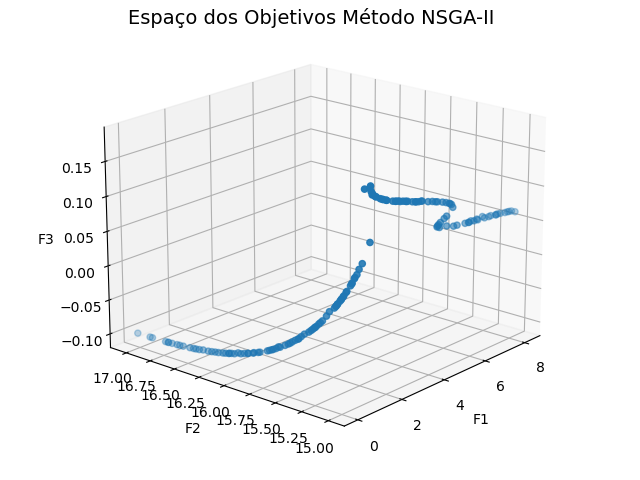

<IPython.core.display.Javascript object>


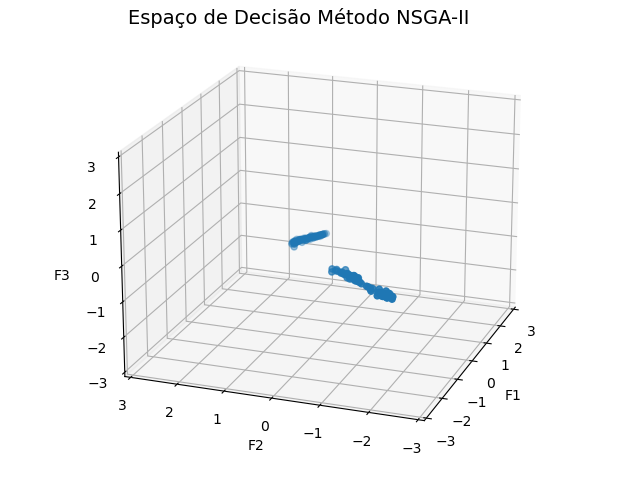

<IPython.core.display.Javascript object>


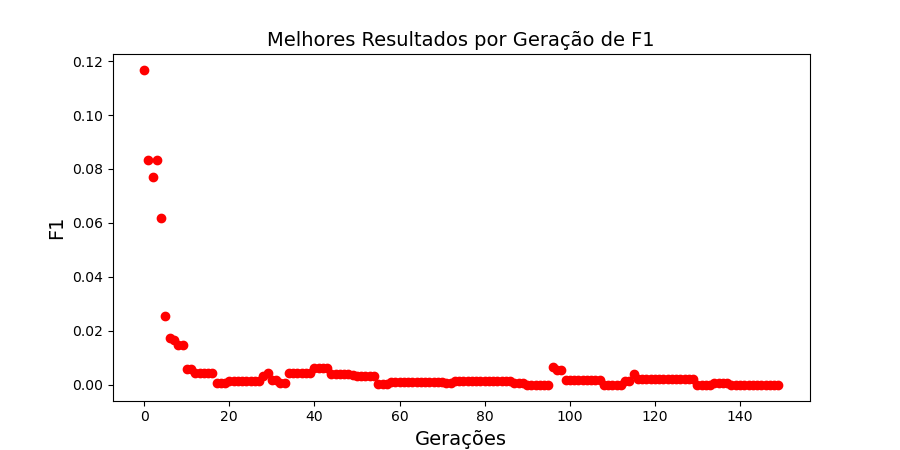

<IPython.core.display.Javascript object>


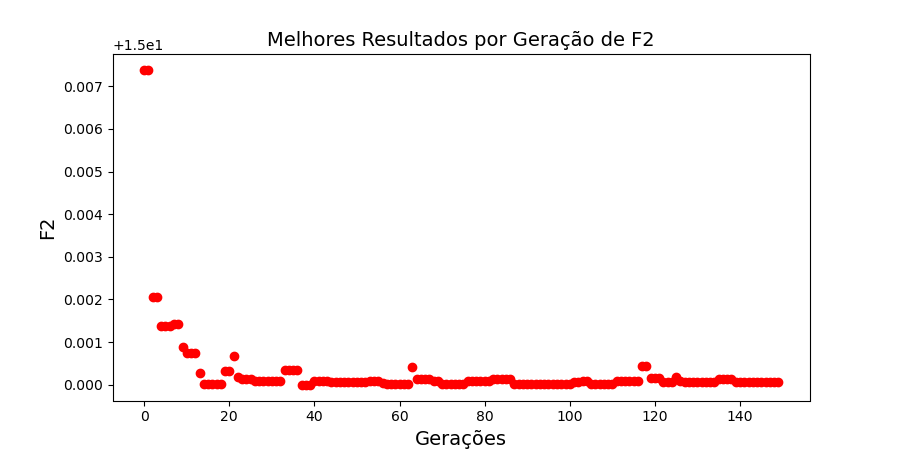

<IPython.core.display.Javascript object>


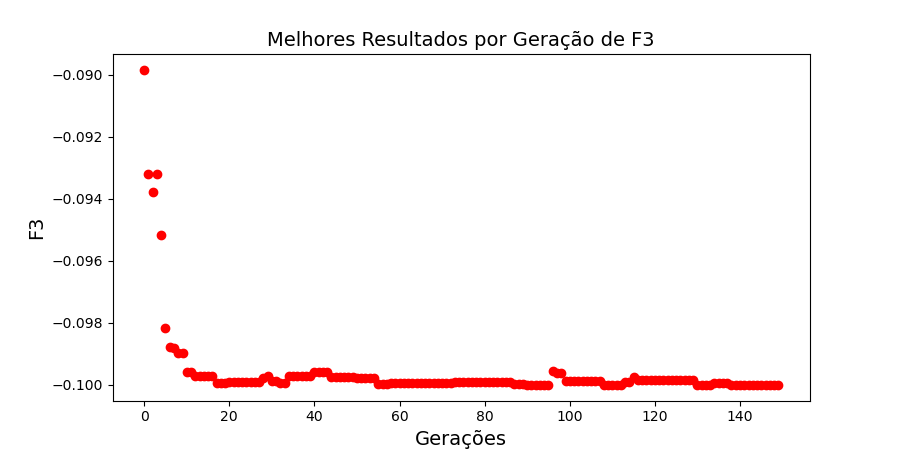

***Método NSGA-II***
Quantidade de pontos:  150
Tempo de execução:  7.236670255661011
________________________________
Média:  -0.9577768953910591
Desvio:  1.077644996792912
Melhor Indivíduo: 
Pior Indivíduo: 


In [210]:
main()